# Nonparametric methods

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Nonparametric Density Estimation

Text(0.5, 1.0, 'poisson')

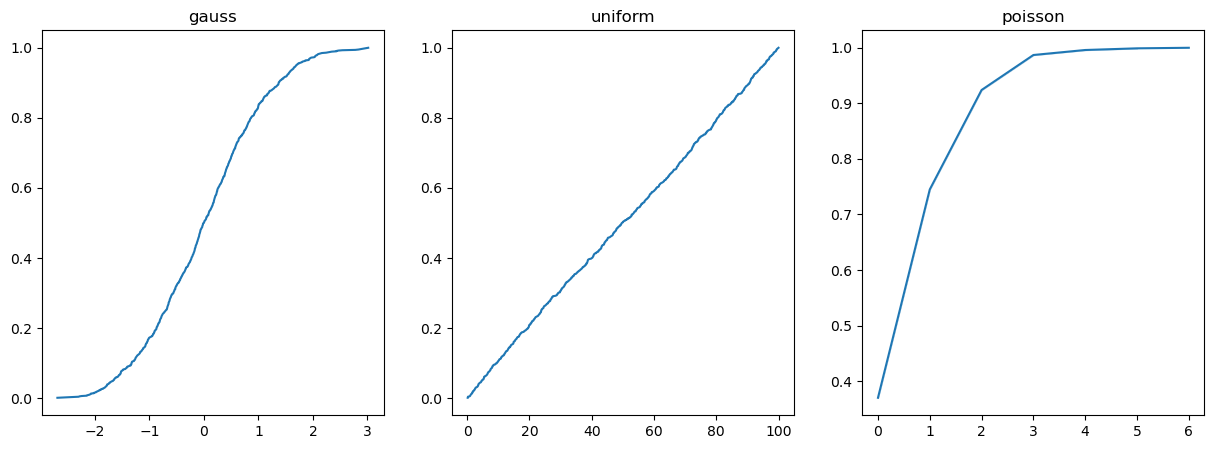

In [8]:
cdf = lambda x: np.sum(x <= x[..., None], axis=1)/x.shape[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

x_gauss = np.random.normal(0, 1, size=(1000,))
x_unifo = np.random.uniform(0, 100, size=(1000,))
x_poiss = np.random.poisson(1, size=(1000,))

sns.lineplot(x=x_gauss, y=cdf(x_gauss), ax=axes[0])
sns.lineplot(x=x_unifo, y=cdf(x_unifo), ax=axes[1])
sns.lineplot(x=x_poiss, y=cdf(x_poiss), ax=axes[2])
axes[0].set_title("gauss")
axes[1].set_title("uniform")
axes[2].set_title("poisson")

(0.0, 1.0)

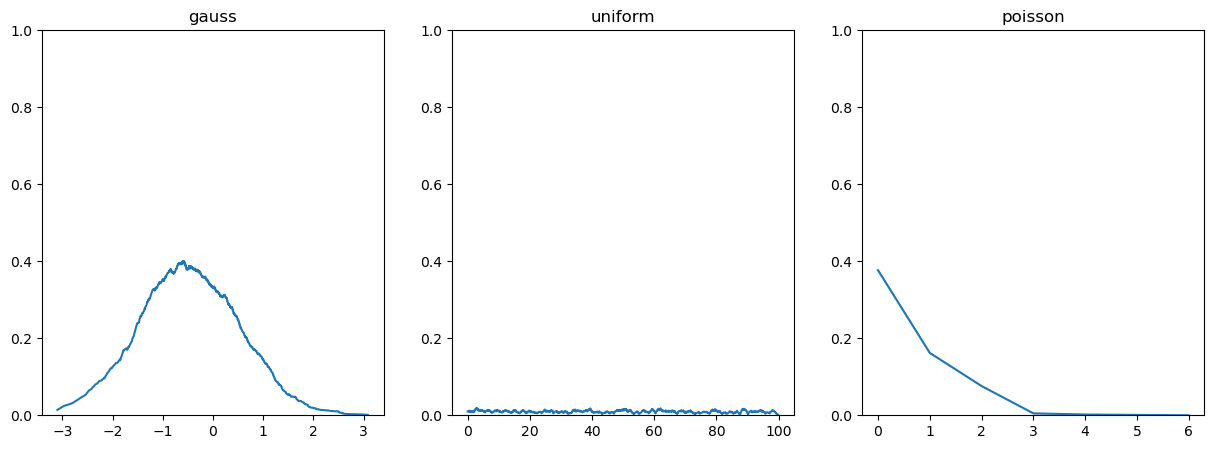

In [127]:
pdf = lambda x, h: 1/h * ((np.sum(x <= (x[..., None] + h), axis=1) - np.sum(x <= x[..., None], axis=1))/x.shape[0])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

h = 1

sns.lineplot(x=x_gauss, y=pdf(x_gauss, h), ax=axes[0])
sns.lineplot(x=x_unifo, y=pdf(x_unifo, h), ax=axes[1])
sns.lineplot(x=x_poiss, y=pdf(x_poiss, h), ax=axes[2])
axes[0].set_title("gauss")
axes[1].set_title("uniform")
axes[2].set_title("poisson")

axes[0].set_ylim((0, 1))
axes[1].set_ylim((0, 1))
axes[2].set_ylim((0, 1))

### Histogram estimator

Interval:
$$
    [x_o + mh, x_o + (m+1)h]
$$
estimate:
$$
    \hat{P}(x) = \dfrac{\#\{x^t \text{ in the same bin as } x\}}{Nh}
$$

In [6]:
import math

def hist_intervals(xo, h, m):
    return [(xo + mi * h, xo + (mi+1) * h) for mi in range(-math.floor(m), math.ceil(m))]

hist_intervals(2, 100, 5)

[(-498, -398),
 (-398, -298),
 (-298, -198),
 (-198, -98),
 (-98, 2),
 (2, 102),
 (102, 202),
 (202, 302),
 (302, 402),
 (402, 502)]

<BarContainer object of 40 artists>

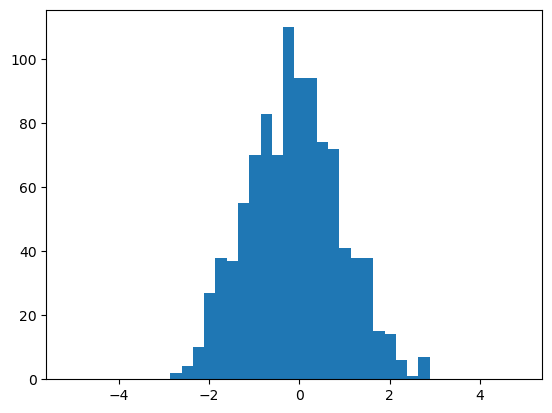

In [44]:
def create_hist(x: np.ndarray, n_bins, width):
    mean = x.mean()
    counter = {
        (l, u): np.where((x <= u) & (x >= l), 1, 0).sum() 
        for (l, u) in hist_intervals(mean, width, n_bins)
    }
    return counter

bin_width = 0.25
n_bins = 20
y = create_hist(x_gauss, n_bins, bin_width)
x = [l for (l, _) in y.keys()]
vals = [v for v in y.values()]

plt.bar(x, width=bin_width, height=vals)

Probability density function of histogram:

<BarContainer object of 1000 artists>

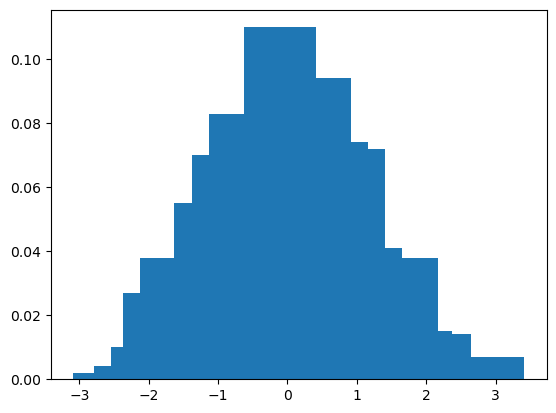

In [36]:
hist_p = lambda x, counter: [v for (l, u), v in counter.items() if l <= x <= u]

p = np.array([hist_p(xi, y) for xi in x_gauss])/x_gauss.shape[0]

plt.bar(x_gauss, p[:, 0])

### Naive estimator

$$
    \hat{P}(x) = \dfrac{\#\{x - h/2 < x^t \leq x + h/2\}}{Nh}
$$

<BarContainer object of 1000 artists>

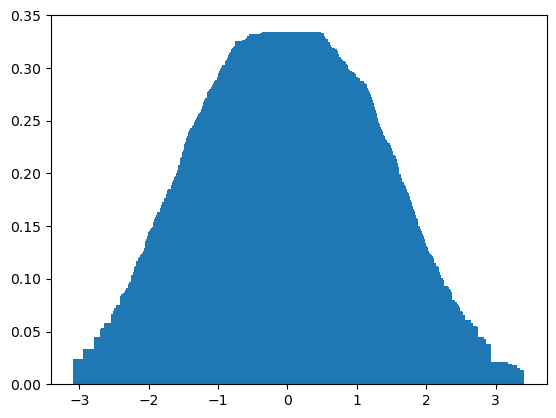

In [46]:
naive_estimator = lambda x, h: np.sum((x[..., None] - h/2 < x) & (x <= x[..., None] + h/2), axis=1)/(x.shape[0]*h)

h = 2
y = naive_estimator(x_gauss, h)

plt.bar(x_gauss, y)

Alternative formula for naive estimator
$$
    \hat{P}(x) = \frac{1}{Nh} \sum_{t=1}^N w \left(\frac{x-x^t}{h}\right)
$$
where 
$$
    w(u) \begin{cases}
        1 & \text{if $|u| < 1/2$}\\
        0 & \text{otherwise}
    \end{cases}
$$

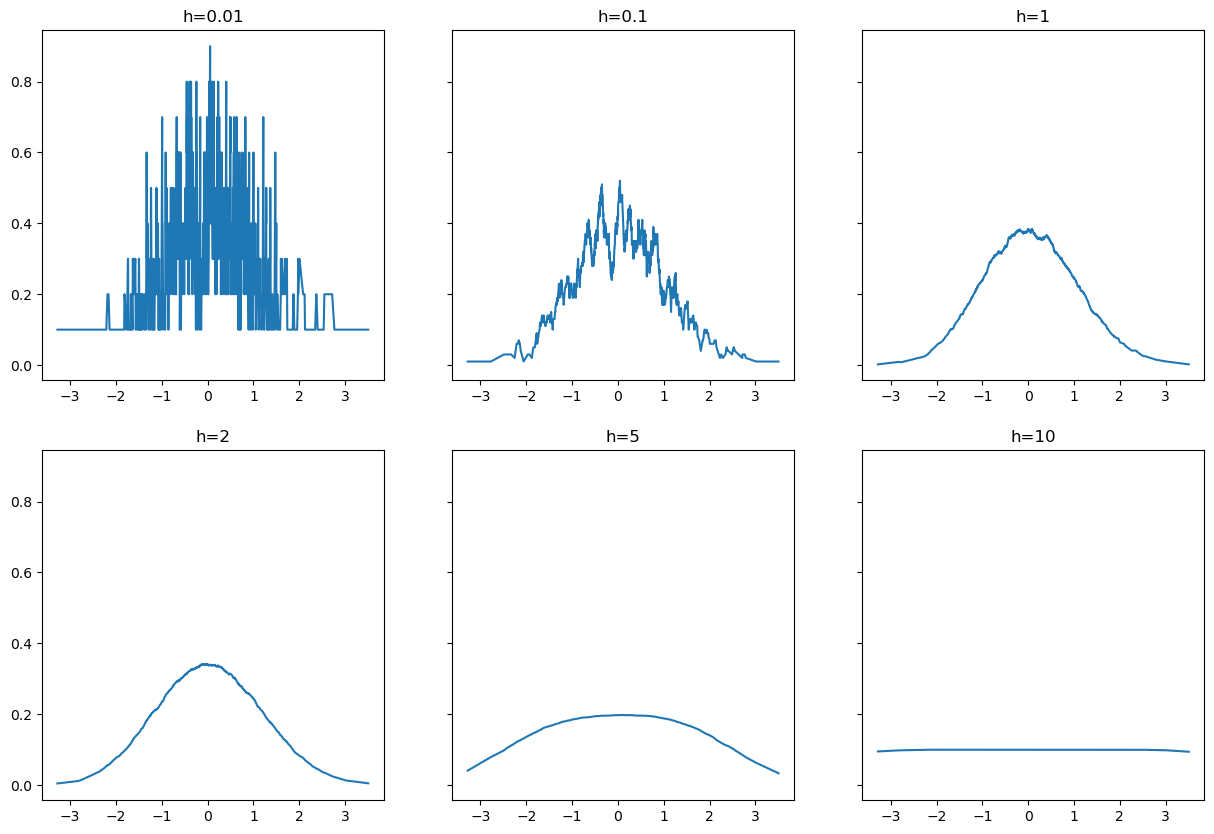

In [286]:
w = lambda x: 1*(np.abs(x) < 0.5)
naive_estimator_alt = lambda x, h: 1/(x.shape[0]*h) * np.sum(w((x[..., None] - x)/h), axis=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

hs = [0.01, 0.1, 1, 2, 5, 10]
for i, h in enumerate(hs):
    y = naive_estimator_alt(x_gauss, h)
    sns.lineplot(x=x_gauss, y=y, ax=axes[i])
    axes[i].set_title(f"{h=}")

### Kernel Estimator

$$
    \hat{P}(x) = \frac{1}{Nh} \sum_{t=1}^N K \left(\frac{x-x^t}{h}\right)
$$
where 
$$
    K(u) = \frac{1}{\sqrt{2\pi}} \exp{\left[-\frac{u^2}{2}\right]}
$$

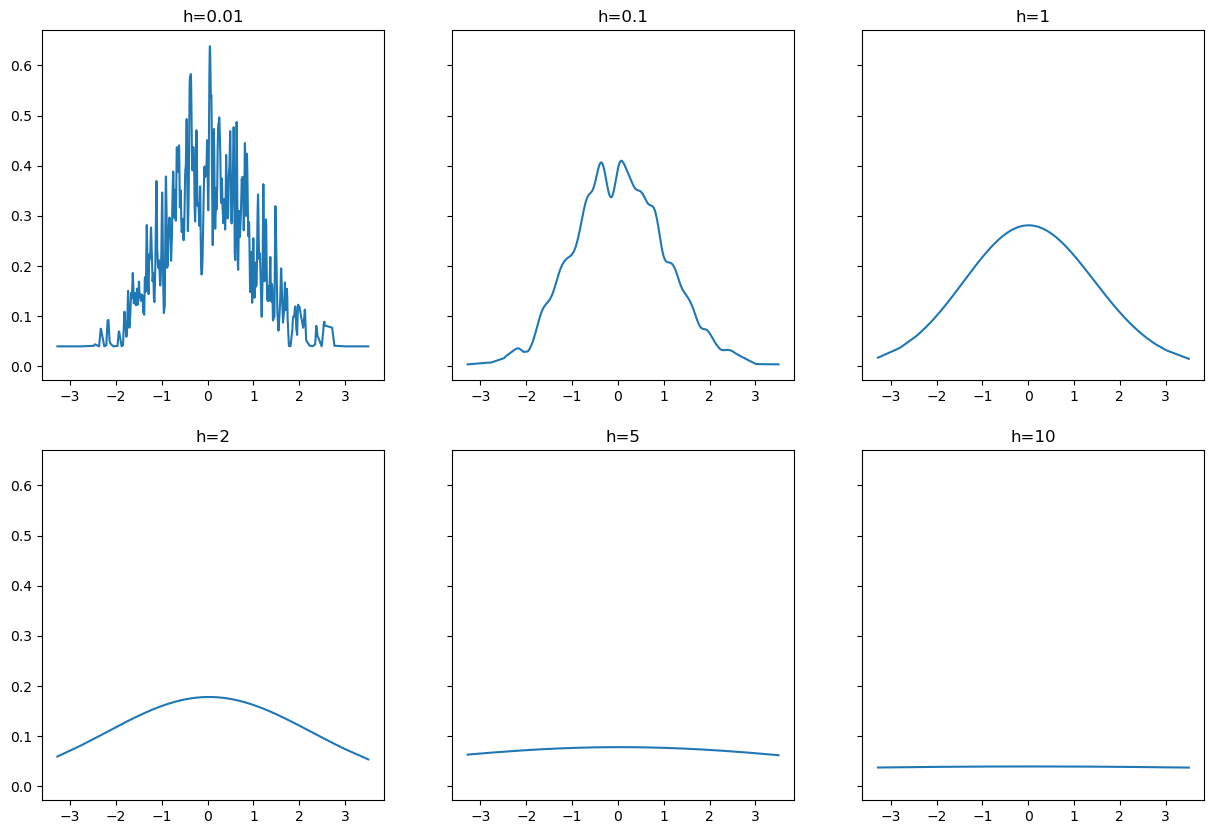

In [292]:
k = lambda x: 1/np.sqrt(2*np.pi) * np.exp(-x**2 / 2)
kernel_estimator = lambda x, h: 1/(x.shape[0]*h) * np.sum(k((x[..., None] - x)/h), axis=1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

hs = [0.01, 0.1, 1, 2, 5, 10]
for i, h in enumerate(hs):
    y = kernel_estimator(x_gauss, h)
    sns.lineplot(x=x_gauss, y=y, ax=axes[i])
    axes[i].set_title(f"{h=}")

### K-Nearest Neighbours Estimator

In [6]:
# test univariate sample
x = np.array([1, 3, 4, 10, 13, 43, 44, 51], dtype=np.float64)

# distance metric: absolute distance
abs_diff = np.abs(x[..., None] - x)
# diagonal is |x-x| = 0, thus these are set to inf
np.fill_diagonal(abs_diff, np.inf)

# find indices of minima along axis 0 (for each column)
min_indices = abs_diff.argmin(axis=0)

# between x1 and x2 is a distance of dist
print("1-nearest neighbours:\n   x1  x2  d\n--------------")
print(np.array([(xi, x[mini], abs_diff[mini, i]) for i, (mini, xi) in enumerate(zip(min_indices, x))]))

1-nearest neighbours:
   x1  x2  d
--------------
[[ 1.  1.  0.]
 [ 3.  3.  0.]
 [ 4.  4.  0.]
 [10. 10.  0.]
 [13. 13.  0.]
 [43. 43.  0.]
 [44. 44.  0.]
 [51. 51.  0.]]


C:\Users\janba\AppData\Local\Temp\ipykernel_26792\118009071.py:6: RuntimeWarning: divide by zero encountered in divide
  return k/(2*x.shape[0] * abs_diff[k-1, :])


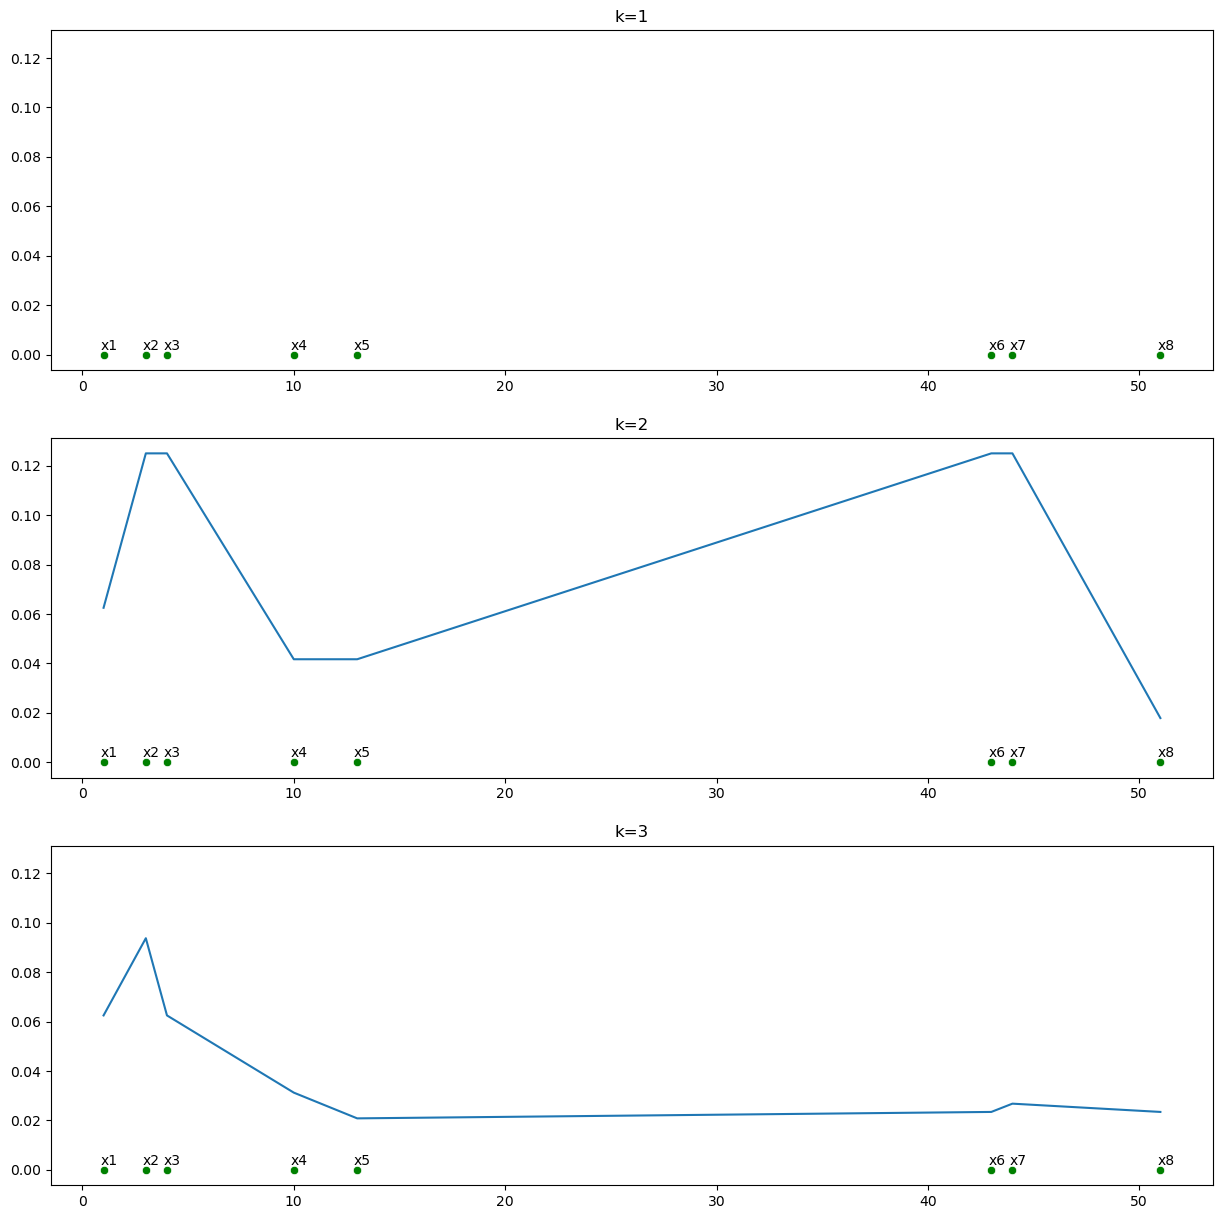

In [5]:
def knn_estimator(x: np.ndarray, k=1):

    abs_diff = np.abs(x[..., None] - x)
    # np.fill_diagonal(abs_diff, np.inf)
    abs_diff.sort(axis=0)
    return k/(2*x.shape[0] * abs_diff[k-1, :])

fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharey=True)
axes = axes.flatten()

ks = [1, 2, 3]
for i, k in enumerate(ks):
    sns.scatterplot(x=x, y=np.zeros_like(x), c='g', ax=axes[i])
    sns.lineplot(x=x, y=knn_estimator(x, k), ax=axes[i])
    for xi, j in enumerate(x):
        axes[i].text(j-0.15, 0.002, f"x{xi+1}")
    axes[i].set_title(f"{k=}")

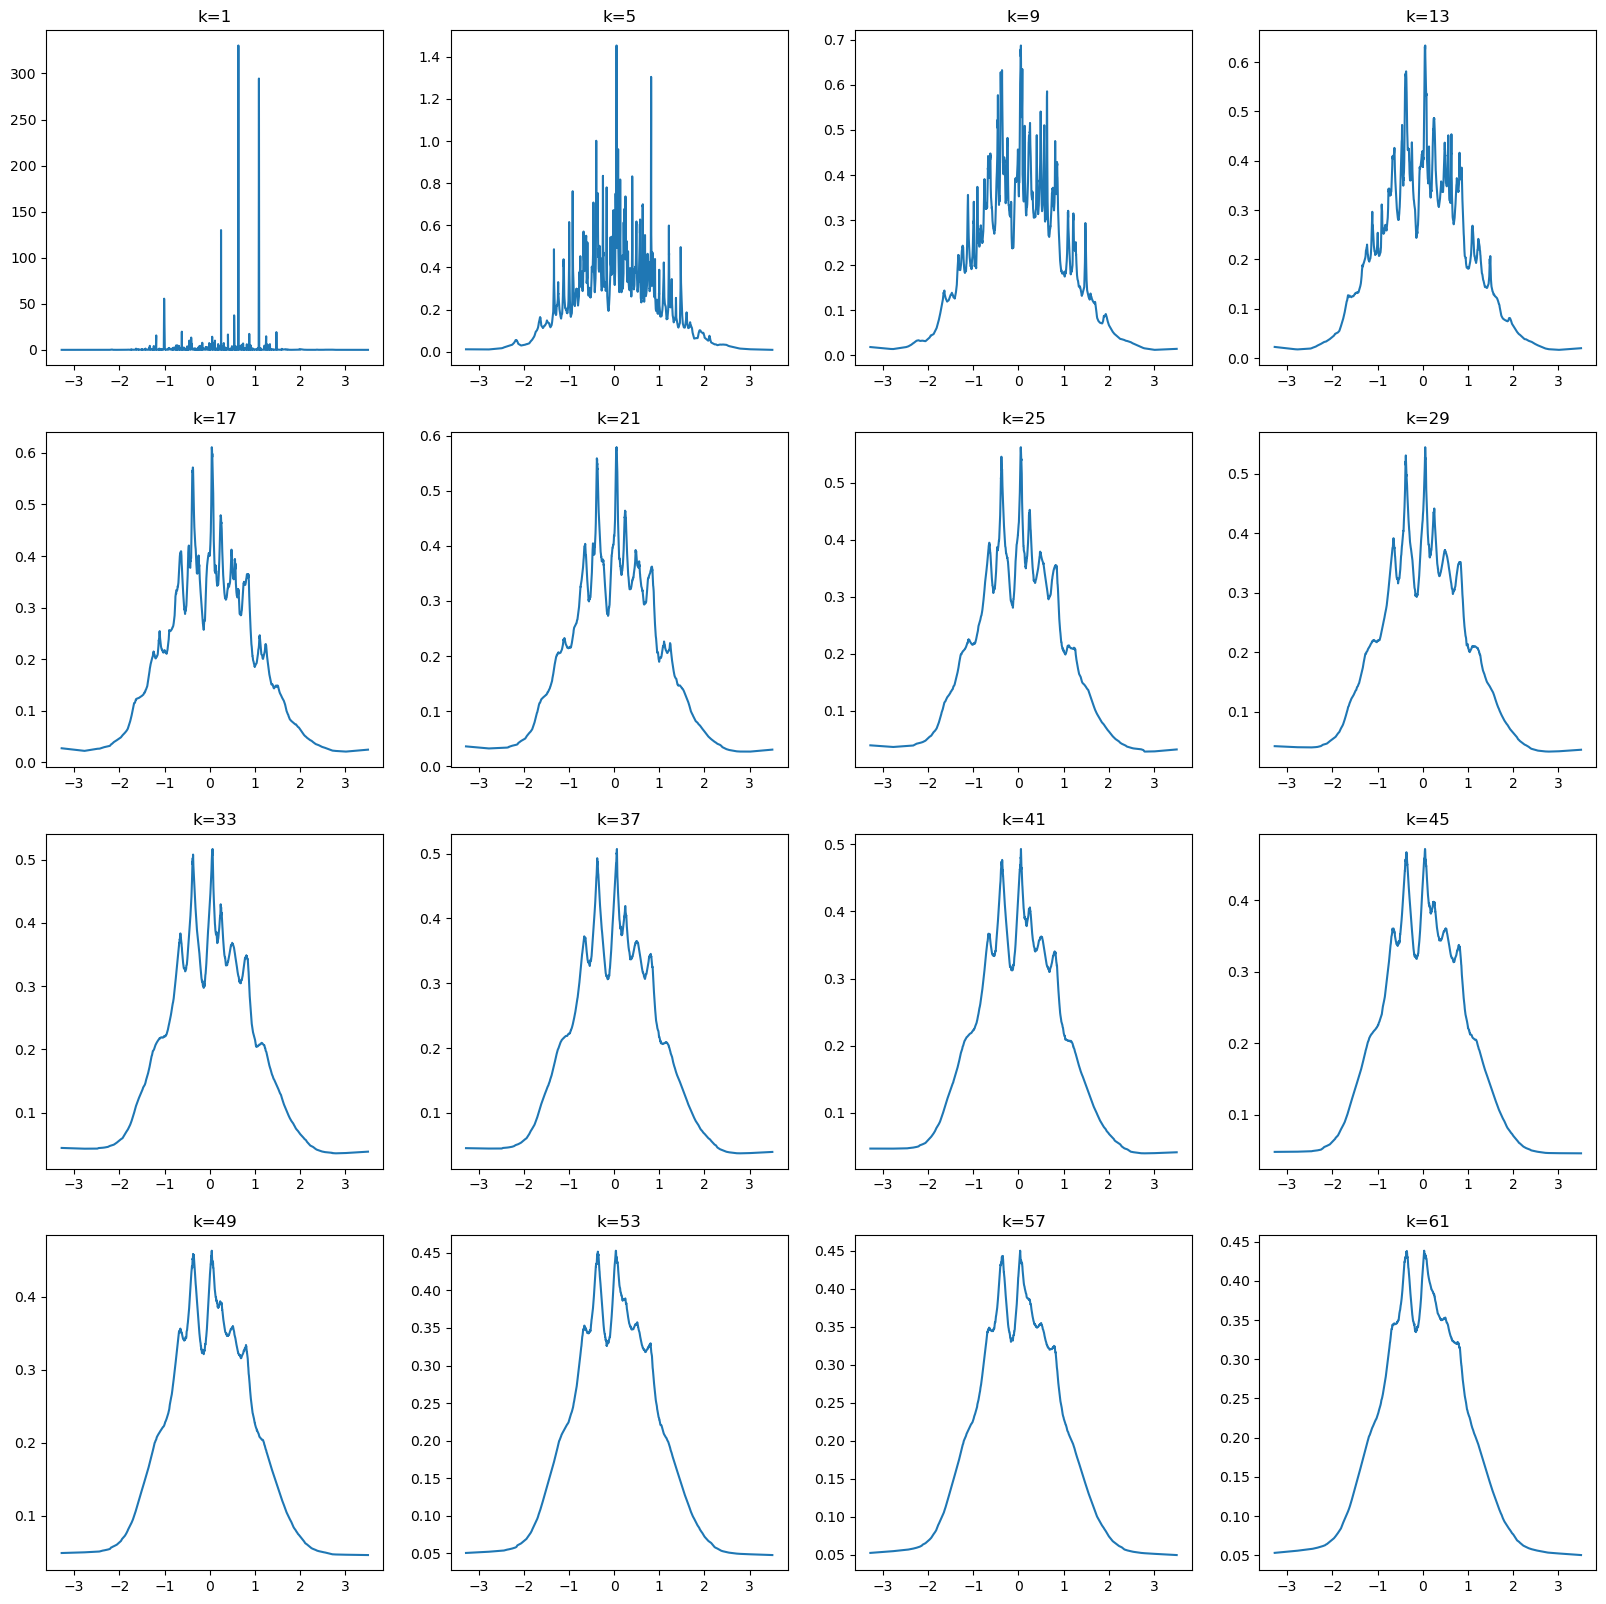

In [448]:
K = lambda x: 1/np.sqrt(2*np.pi) * np.exp(-x**2 / 2)

def kernel_knn_estimator(x: np.ndarray, k=1):

    abs_diff = np.abs(x[..., None] - x)
    np.fill_diagonal(abs_diff, np.inf)
    abs_diff.sort(axis=0)
    return 1/(x.shape[0] * abs_diff[k-1, :]) * np.sum(K((x[..., None] - x)/abs_diff[k-1, :]), axis=0)


fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=False)
axes = axes.flatten()

ks = [1, 10, 50, 100]
for i, k in enumerate(range(1, 65, 4)):
    sns.lineplot(x=x_gauss, y=kernel_knn_estimator(x_gauss, k), ax=axes[i])
    axes[i].set_title(f"{k=}")

## Multivariate estimators

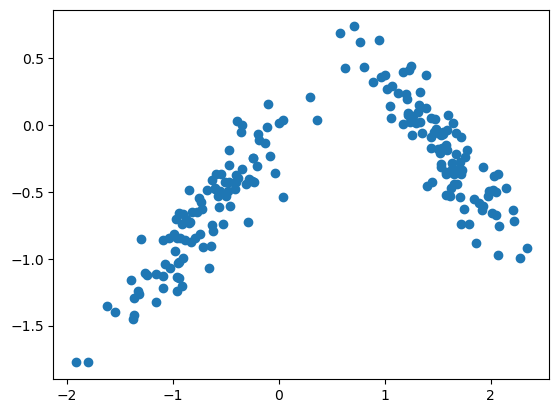

In [382]:
X1 = np.random.multivariate_normal([0, 0], [[1, 0.9], [0.9, 1]], size=(50, 2)).reshape(100, 2)
X2 = np.random.multivariate_normal([5, 1], [[1, -0.9], [-0.9, 1]], size=(50, 2)).reshape(100, 2)
X = np.vstack((X1, X2))
X = (X - X.mean())/X.std()
plt.scatter(X[:, 0], X[:, 1])

### Euclidean distance

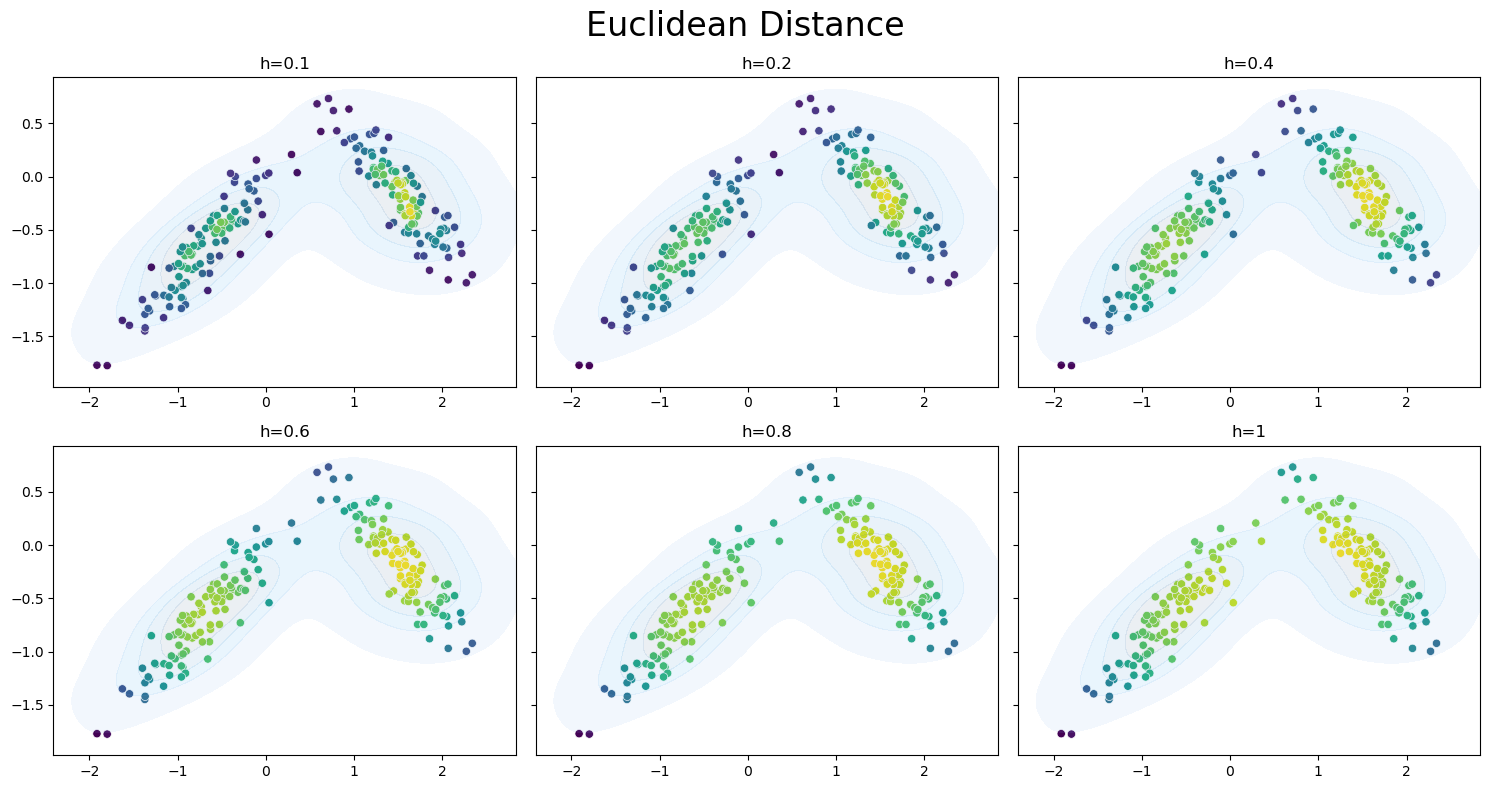

In [400]:
multi_k = lambda x: 1/(2*np.pi)**(x.shape[1]/2) * np.exp(-np.linalg.norm(x, axis=1)**2 / 2)
multi_kernel_estimator = lambda x, h: 1/(x.shape[0]*h**x.shape[1]) * np.sum(multi_k((x[..., None] - x[..., None].T)/h), axis=0)

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

hs = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
for i, h in enumerate(hs):
    axes[i].set_title(f"{h=}")
    y = multi_kernel_estimator(X, h)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, cmap="viridis", ax=axes[i])
    sns.kdeplot(x=X[:, 0], y=X[:, 1], levels=5, fill=True, alpha=0.1, cut=1, ax=axes[i])

fig.suptitle('Euclidean Distance', fontsize=24)
plt.tight_layout()

### Mahalanobis distance

Playing around with matrix broadcasting

In [263]:
x = np.array([
    [1, 2],
    [2, 5],
    [1, 6]
])

In [300]:
S = np.cov(x, rowvar=False)
S

array([[0.33333333, 0.33333333],
       [0.33333333, 4.33333333]])

In [339]:
# for each vector, copy it 3 times, and for the entire dataset, copy it 3 times via broadcasting
np.broadcast_to(x[..., None, :], shape=(3, 3, 2)), np.repeat(x[None, :], 3, axis=0)

(array([[[1, 2],
         [1, 2],
         [1, 2]],
 
        [[2, 5],
         [2, 5],
         [2, 5]],
 
        [[1, 6],
         [1, 6],
         [1, 6]]]),
 array([[[1, 2],
         [2, 5],
         [1, 6]],
 
        [[1, 2],
         [2, 5],
         [1, 6]],
 
        [[1, 2],
         [2, 5],
         [1, 6]]]))

In [353]:
np.broadcast_to(x[..., None, :], shape=(3, 3, 2)) - np.repeat(x[None, :], 3, axis=0)

array([[[ 0,  0],
        [-1, -3],
        [ 0, -4]],

       [[ 1,  3],
        [ 0,  0],
        [ 1, -1]],

       [[ 0,  4],
        [-1,  1],
        [ 0,  0]]])

In [341]:
res = np.broadcast_to(x[..., None, :], shape=(3, 3, 2)) - np.repeat(x[None, :], 3, axis=0)
# transpose the second and third dimension (keep the first dimension as is)
np.transpose(res, axes=(0, 2, 1))

array([[[ 0, -1,  0],
        [ 0, -3, -4]],

       [[ 1,  0,  1],
        [ 3,  0, -1]],

       [[ 0, -1,  0],
        [ 4,  1,  0]]])

In [354]:
# same thing as above
x[..., None] - x[..., None].T

array([[[ 0, -1,  0],
        [ 0, -3, -4]],

       [[ 1,  0,  1],
        [ 3,  0, -1]],

       [[ 0, -1,  0],
        [ 4,  1,  0]]])

In [349]:
res_T = np.transpose(res, axes=(0, 2, 1))
# dot product of S @ res.T = (2, 2) @ (3, 2, 3) = (3, 2, 3)
# dot product of res @ (S @ res.T) = (3, 3, 2) @ (3, 2, 3) = (3, 3, 3)
# 
# sum over dim 1 and 2:
#   dim 1 => (3, 3)
#   dim 2 => (3, )
np.sum(res @ S @ res_T, axis=(2, 1)).shape

(3,)

Implementing mahalonobis distance in multivariate kernel function

$$
    K(\mathbf{u}) = \dfrac{1}{(2\pi)^{d/2} |\mathbf{S}|^{1/2} } \exp\left[-\frac{1}{2} \mathbf{u}^T \mathbf{S}^{-1} \mathbf{u} \right]
$$

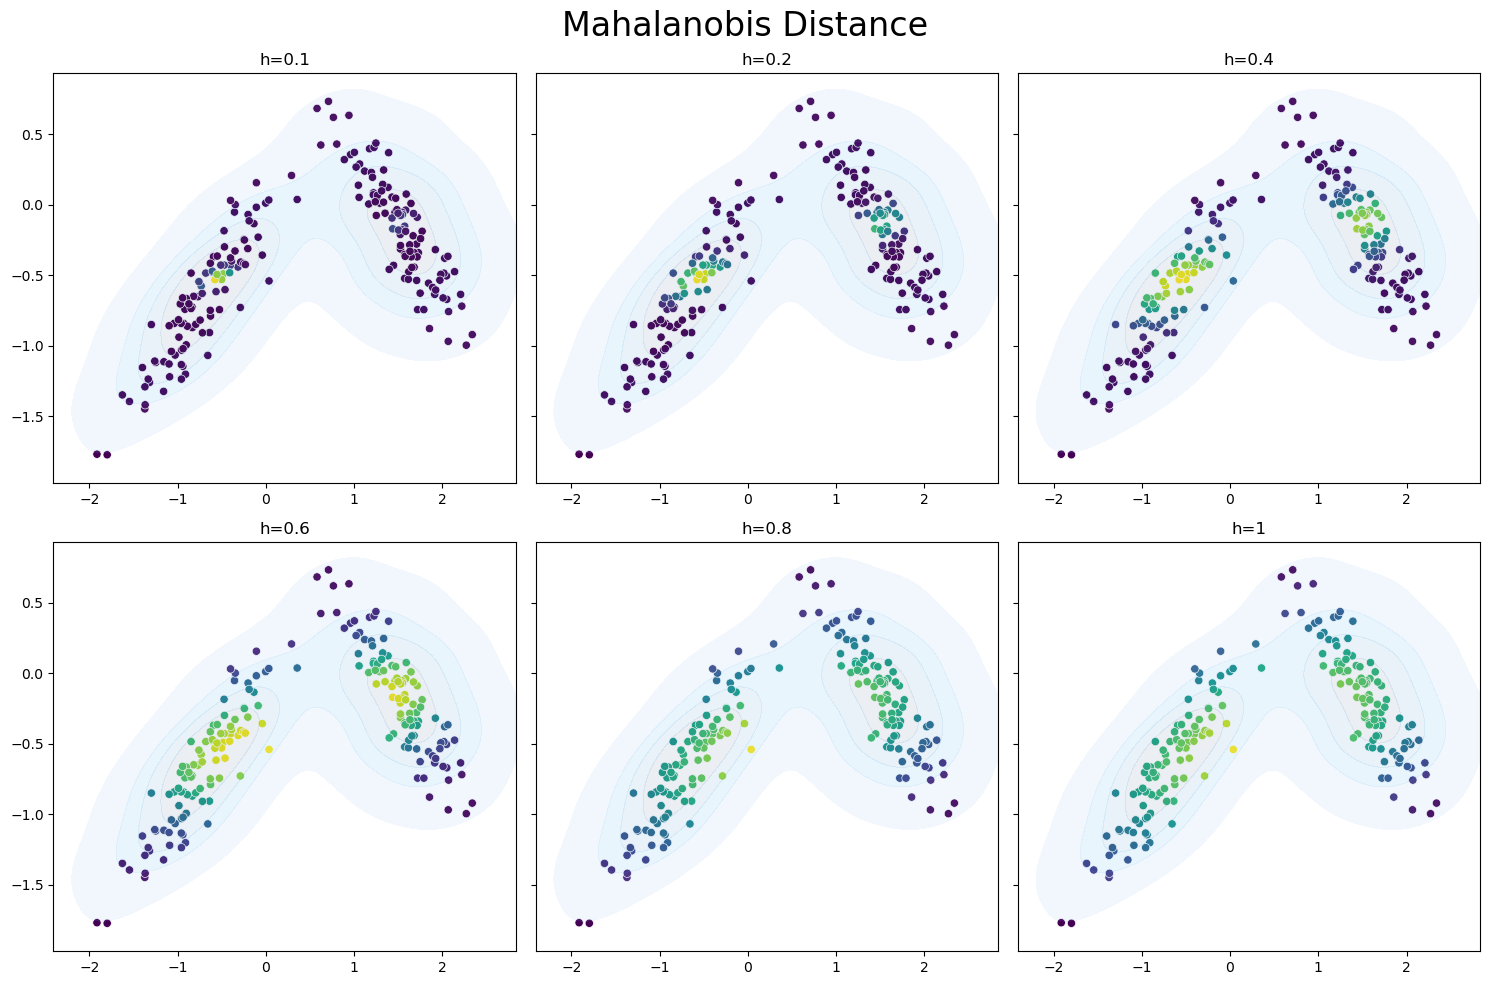

In [401]:
def multi_k(x, S):
    det = np.linalg.det(S)
    inv_S = np.linalg.pinv(S)
    x_T = np.transpose(x, axes=(0, 2, 1))
    return 1/((2*np.pi)**(x.shape[1]/2) * det**0.5) * np.exp(-0.5 * x_T @ inv_S @ x)

def multi_kernel_estimator(x, h):
    N = x.shape[0]
    d = x.shape[1]
    S = np.cov(x, rowvar=False)
    x_minus_xt = x[..., None] - x[..., None].T
    return 1/(N*h**d) * np.sum(multi_k(x_minus_xt/h, S), axis=(2, 1))

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

hs = [0.1, 0.2, 0.4, 0.6, 0.8, 1]
for i, h in enumerate(hs):
    axes[i].set_title(f"{h=}")
    y = multi_kernel_estimator(X, h)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, cmap="viridis", ax=axes[i])
    sns.kdeplot(x=X[:, 0], y=X[:, 1], levels=5, fill=True, alpha=0.1, cut=1, ax=axes[i])

fig.suptitle('Mahalanobis Distance', fontsize=24)
plt.tight_layout()

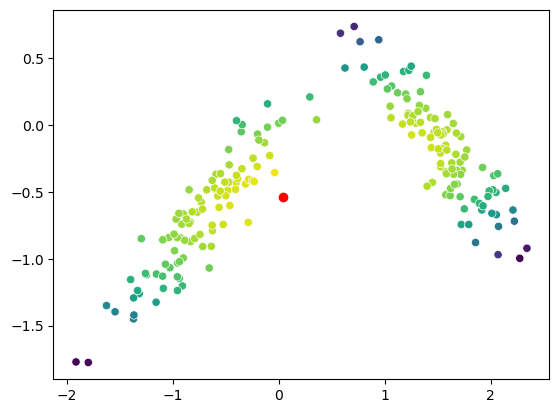

In [392]:
y = multi_kernel_estimator(X, 100)
sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, cmap="viridis")
# sns.kdeplot(x=X[:, 0], y=X[:, 1], levels=5, fill=True, alpha=0.1, cut=1)
y[y.argmax()]
plt.scatter(X[y.argmax(), 0], y=X[y.argmax(), 1], c='r')

### KNN multivariate

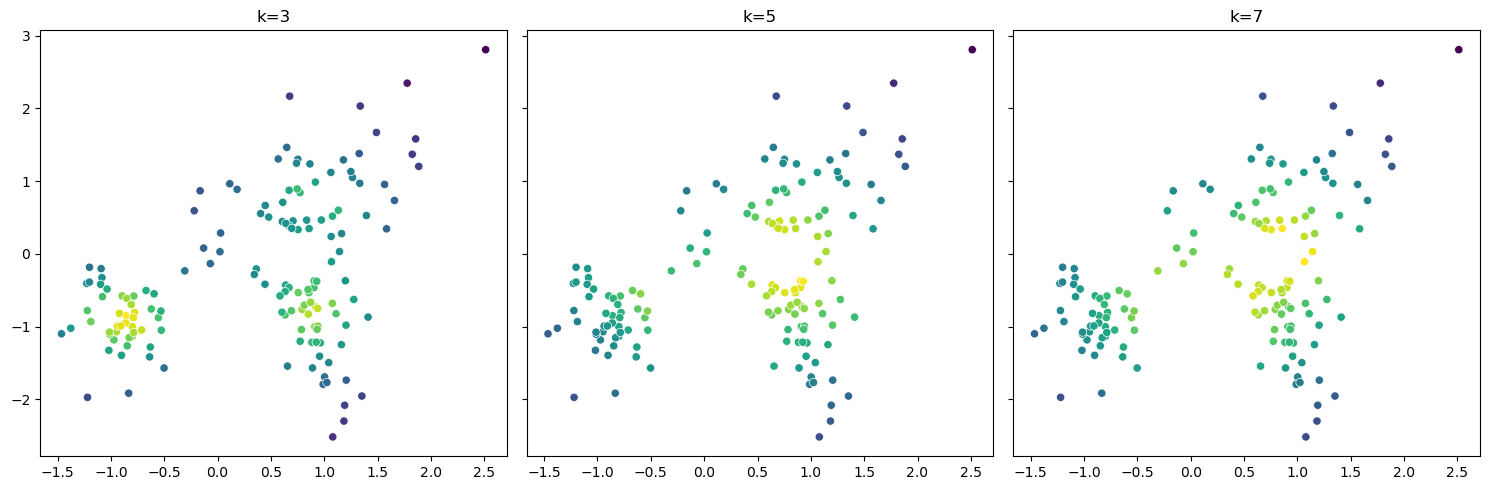

In [899]:
def knn_estimator(x: np.ndarray, k=1):

    abs_diff = np.sum(np.abs(np.transpose(x[..., None]-x[..., None].T, axes=(0, 2, 1))), axis=2).T
    abs_diff.sort(axis=0)
    return k/(2*x.shape[0] * abs_diff[k-1, :])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
axes = axes.flatten()

ks = [3, 5, 7]
for i, k in enumerate(ks):
    y = knn_estimator(X, k*10)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], c=y, ax=axes[i])
    axes[i].set_title(f"{k=}")

plt.tight_layout()

## Nonparametric Classification

<AxesSubplot: >

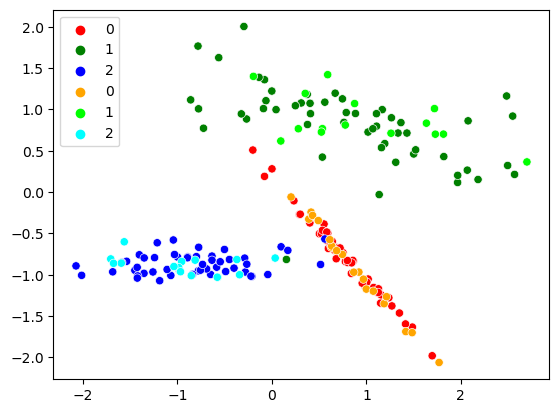

In [2]:
from sklearn.datasets import make_classification

X, Y = make_classification(
    n_samples=200, 
    n_features=2, 
    n_informative=2, 
    n_redundant=0, 
    n_repeated=0, 
    n_classes=3,
    n_clusters_per_class=1,
    class_sep=1.2
)

X = (X - X.mean())/X.std()

X_test = X[:50, :]
Y_test = Y[:50]
X = X[50:, :]
Y = Y[50:]

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=Y, palette=['r', 'g', 'b'])
sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=Y_test, palette=['orange', 'lime', 'cyan'])

### Example: synthetic dataset

C:\Users\janba\AppData\Local\Temp\ipykernel_7812\1524070672.py:41: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette=['r', 'g', 'b'], ax=axes[i])


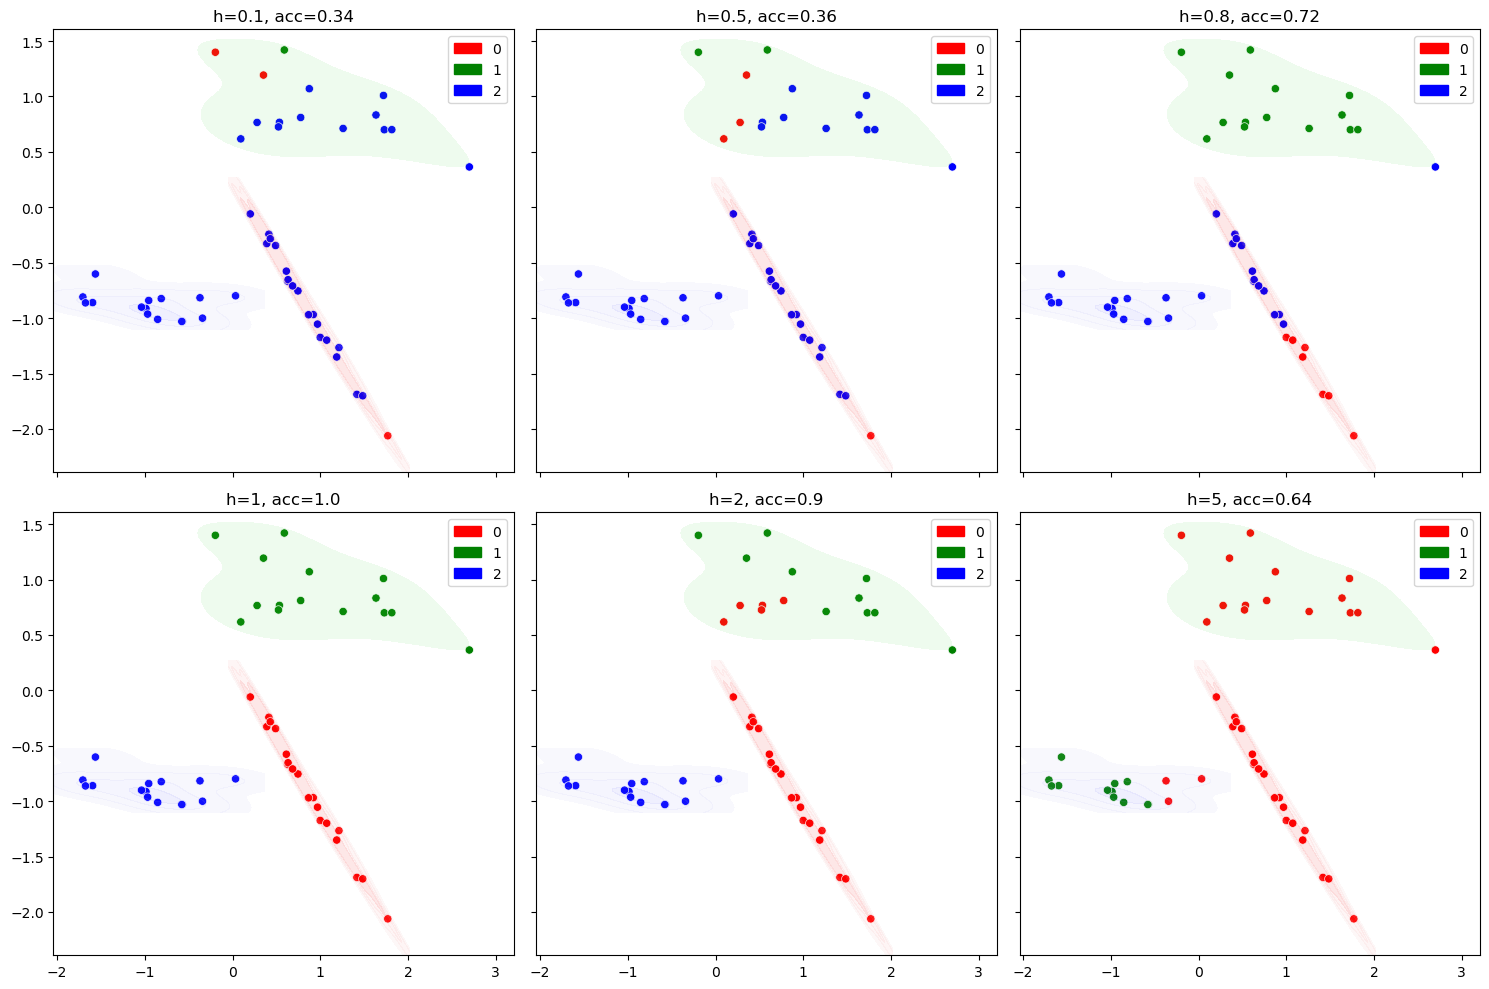

In [3]:
euclid_multi_k = lambda x: 1/(2*np.pi)**(x.shape[1]/2) * np.exp(-np.linalg.norm(x, axis=1)**2 / 2)
euclid_multi_kernel_estimator = lambda x, h: 1/(x.shape[0]*h**x.shape[1]) * np.sum(euclid_multi_k((x[..., None] - x[..., None].T)/h), axis=0)

def mahalan_multi_k(x, S):
    det = np.linalg.det(S)
    inv_S = np.linalg.pinv(S)
    x_T = np.transpose(x, axes=(0, 2, 1))
    return 1/((2*np.pi)**(x.shape[1]/2) * det**0.5) * np.exp(-0.5 * x_T @ inv_S @ x)

def mahalan_multi_kernel_estimator(x, h):
    N = x.shape[0]
    d = x.shape[1]
    S = np.cov(x, rowvar=False)
    x_minus_xt = x[..., None] - x[..., None].T
    return 1/(N*h**d) * np.sum(mahalan_multi_k(x_minus_xt/h, S), axis=(2, 1))

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
axes = axes.flatten()

hs = [0.1, 0.5, 0.8, 1, 2, 5]
color_maps = [
    sns.color_palette("dark:#F00", as_cmap=True),
    sns.color_palette("dark:#0F0", as_cmap=True),
    sns.color_palette("dark:#00F", as_cmap=True),
]

for i, h in enumerate(hs):

    guesses = []
    for j, col in enumerate(color_maps):
        X_Ci = X[Y == j]
        x = np.vstack([X_Ci, X_test])
        y = mahalan_multi_kernel_estimator(x, h)
        y = y[X_Ci.shape[0]:]
        guesses.append(y)

    guesses = np.array(guesses)
    y_pred = guesses.argmax(axis=0)
    acc = np.sum(y_pred == Y_test)/Y_test.shape[0]

    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette=['r', 'g', 'b'], ax=axes[i])
    sns.kdeplot(x=X_test[:, 0], y=X_test[:, 1], levels=5, hue=Y_test, palette=['r', 'g', 'b'], fill=True, alpha=0.1, cut=1, ax=axes[i])
    axes[i].set_title(f"{h=}, {acc=}")
        
plt.tight_layout()

In [5]:
guesses = []
hs = [0.86, 0.95, 1]

for j, h in enumerate(hs):
    X_Ci = X[Y == j]
    x = np.vstack([X_Ci, X_test])
    y = mahalan_multi_kernel_estimator(x, h)
    y = y[X_Ci.shape[0]:]
    guesses.append(y)

guesses = np.array(guesses)
acc = np.sum(guesses.argmax(axis=0) == Y_test)/Y_test.shape[0]
print(f"{acc=}")
guesses.argmax(axis=0) == Y_test


acc=0.88


array([ True,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False])

### KNN Classifier

#### Very simple example

(array([[1, 2],
        [3, 5],
        [4, 3]]),
 array([0, 1, 1]))

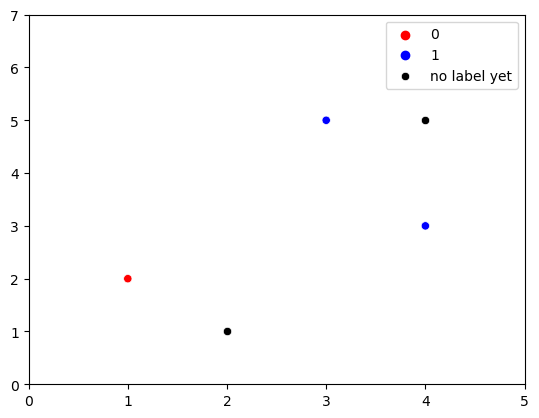

In [6]:
y = np.array([0, 1, 1])
x = np.array([
    [1, 2],
    [3, 5],
    [4, 3]
])

# test set
xt = np.array([[2, 1], [4, 5]])

plt.xlim(0, 5)
plt.ylim(0, 7)
sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, palette=['r', 'b'])
sns.scatterplot(x=xt[:, 0], y=xt[:, 1], c='black', label='no label yet')

x, y

In [7]:
# look at 2-nearest neighbours
k=2

# broadcast (3,) y labels to (3, 2) 
y_mat = np.broadcast_to(y[..., None], shape=(x.shape[0], xt.shape[0]))

# (2, 2, 1) xt - (1, 2, 3) x.T = (2, 2, 3)
x_test_minus_x = xt[..., None]-x[..., None].T
# transpose second and third axes: (2, 2, 3) -> (2, 3, 2)
x_test_minus_x_T = np.transpose(x_test_minus_x, axes=(0, 2, 1))
# sum over axis 2: (2, 3, 2) -> (2, 3)
# transpose: (2, 3) -> (3, 2) same dims as y_mat
abs_diff = np.sum(np.abs(x_test_minus_x_T), axis=2).T

i = abs_diff.argsort(axis=0)

# sort y labels based on absolute differences (nearest neighbours)
y_mat_sorted = np.take_along_axis(y_mat, i, axis=0)
y_mat_sorted_kn = y_mat_sorted[:k, :] # take only the k nearest neighbours

classes = np.unique(y)
# from the k nearest, sum all that have the same label and store in vector
ki = (y_mat_sorted_kn == classes.reshape(classes.shape[0], 1, 1)).sum(axis=1) 

# P(C_i | x) \propto
p_ci_x = ki/k
p_ci_df = pd.DataFrame(p_ci_x/ p_ci_x.sum(axis=1)[..., None], columns=['C0', 'C1'])
p_ci_df

,C0,C1
0,1.000000,0.000000
1,0.333333,0.666667


#### 3 class KNN classifier

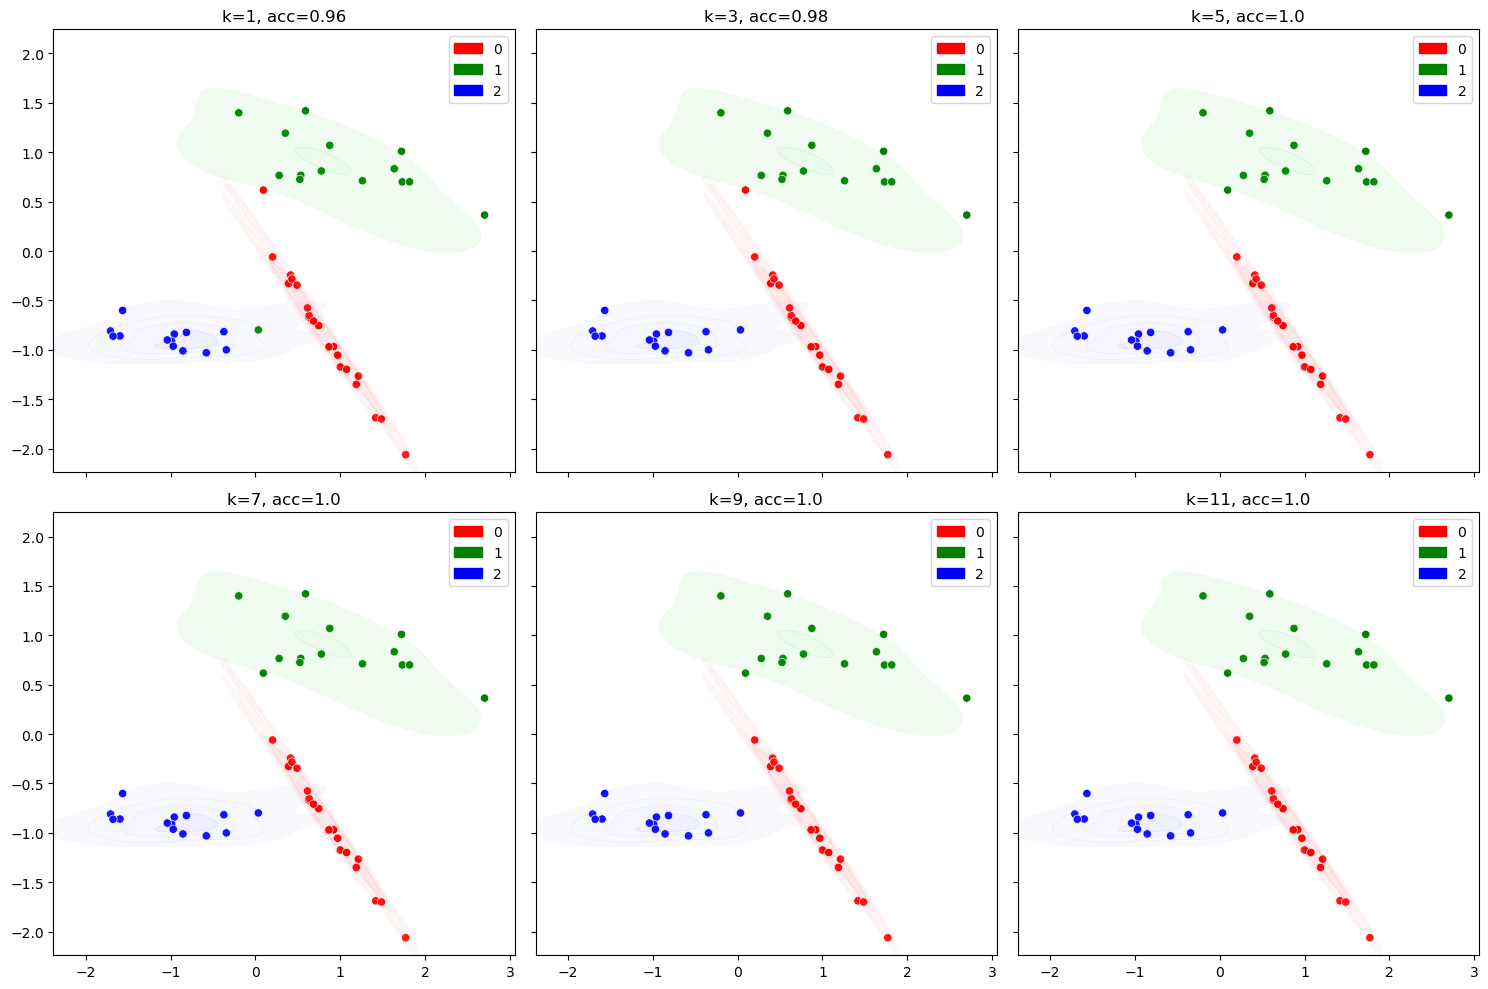

In [10]:
def knn_estimator(x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, k=3):
    
    y_mat = np.broadcast_to(y_train[..., None], shape=(x_train.shape[0], x_test.shape[0]))

    abs_diff = np.sum(np.abs(np.transpose(x_test[..., None]-x_train[..., None].T, axes=(0, 2, 1))), axis=2).T
    i = abs_diff.argsort(axis=0)

    y_mat_sorted = np.take_along_axis(y_mat, i, axis=0)
    y_mat_sorted_kn = y_mat_sorted[:k, :]

    classes = np.unique(y_train)
    ki = (y_mat_sorted_kn == classes.reshape(classes.shape[0], 1, 1)).sum(axis=1)

    return ki/k

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
axes = axes.flatten()

ks = [1, 3, 5, 7, 9, 11]
for i, k in enumerate(ks):
    
    guesses = knn_estimator(X, Y, X_test, k)
    y_pred = guesses.argmax(axis=0)
    acc = np.sum(y_pred == Y_test)/Y_test.shape[0]
    
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_pred, palette=['r', 'g', 'b'], ax=axes[i])
    sns.kdeplot(x=X[:, 0], y=X[:, 1], levels=5, hue=Y, palette=['r', 'g', 'b'], fill=True, alpha=0.1, cut=1, ax=axes[i])
    axes[i].set_title(f"{k=}, {acc=}")

plt.tight_layout()

In [18]:
Z = X[:1, :]

guesses = knn_estimator(X, Y, Z, 1)
y_pred = guesses.argmax(axis=0)
y_pred, guesses, Y[0]

(array([2], dtype=int64),
 array([[0.],
        [0.],
        [1.]]),
 2)

## Distance-based classification

In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

dataset = load_iris()
X = dataset.data
Y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

LMNN: Large Margin Nearest Neighbour:
- Learns Mahalanobis distance such that distance to neighbour with different class is smaller than distance to neighbour with same class
- Can also reduce dimensionality by approximating low rank distance matrix $\mathbf{L}$ 

In [64]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from metric_learn import LMNN
from sklearn.neighbors import KNeighborsClassifier 

k = 3
lmnn = LMNN(n_neighbors=k, n_components=1)
X_emb = lmnn.fit_transform(X_train, y_train)

knn_lmnn = KNeighborsClassifier(n_neighbors=k).fit(X_emb, y_train)
knn_base = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

In [65]:
X_test_emd = lmnn.transform(X_test)

knn_base_acc = (knn_base.predict(X_test) == y_test).sum()/y_test.shape[0]
knn_lmnn_acc = (knn_lmnn.predict(X_test_emd) == y_test).sum()/y_test.shape[0]
print(f"{knn_base_acc=}, {X_test.shape=}")
print(f"{knn_lmnn_acc=}, {X_test_emd.shape=}")

knn_base_acc=0.9333333333333333, X_test.shape=(30, 4)
knn_lmnn_acc=0.9333333333333333, X_test_emd.shape=(30, 1)
